In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from graphviz import Digraph

def trace(root):
    # recursively builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes: 
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
    
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            
            # and connect this node to it
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        # connect n_i to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [2]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # initialising gradients to 0 allows us to accumulate (+=) then when using multivar chain rule case
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})" 

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # accumulate the gradients (+=) bc multivar chain rule (i.e. a node influences the final node MORE THAN ONCE)
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
            
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # accumulate the gradients (+=) bc multivar chain rule (i.e. a node influences the final node MORE THAN ONCE)
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
            
        out._backward = _backward
        
        return out

    def tanh(self): 
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # accumulate the gradients (+=) bc multivar chain rule (i.e. a node influences the final node MORE THAN ONCE)
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

Neuron example (before backprop, all gradients initialised at 0.0)


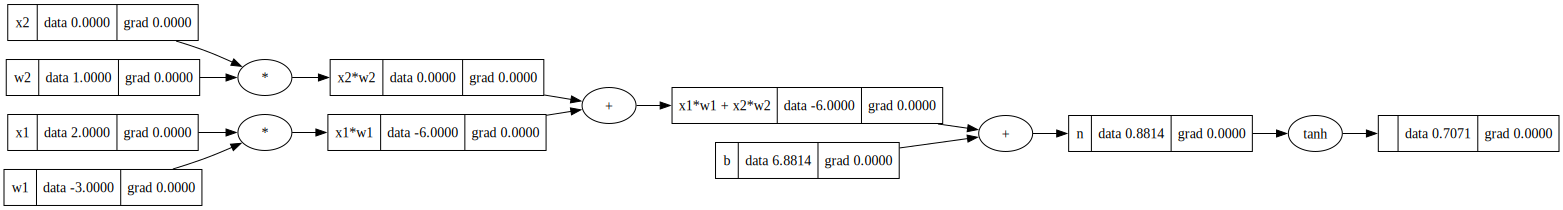

In [3]:
# redefine the inspiring (neuron) example
# neuron inputs x1,x2 (2 dimensional neuron)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of neuron w1,w2 (synaptic strengths for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.881373587019543, label='b')

# following the graph above to create: x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# cell body raw activation (without the activation function)
n = x1w1x2w2 + b; n.label = 'n'

# tanh activation function (a non-linear node)
o = n.tanh()

print('Neuron example (before backprop, all gradients initialised at 0.0)')
draw_dot(o)

Gradients set after running .backward() backpropagation function)


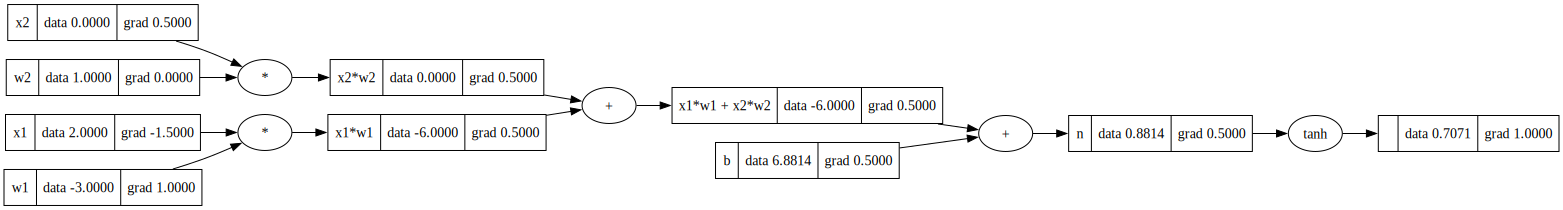

In [4]:
o.backward()
print('Gradients set after running .backward() backpropagation function)')
draw_dot(o)